# Import & Configurasi

## Import

In [81]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

## Configurasi

In [82]:
# ====== KONFIGURASI ======
CSV_PATH   = "C:/Users/madea/Desktop/Kelas_Bagus_3/clustring/DatasetClean40k.csv"  
BLOCK_SIZE = 10_000                      # 10k baris per game
LABELS     = ["AOV", "MLBB", "HOK", "LoL"]
TEXT_COL   = "clean_content"

# TF-IDF
MAX_FEATURES = 10000      
MIN_DF = 5
MAX_DF = 0.90
NGRAM  = (1, 2)

# Rentang k yang diuji
K_VALUES = list(range(5, 13))   # k=5..12
RAND = 42


# load and Tag Game

In [83]:
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=[TEXT_COL])
df = df[df[TEXT_COL].astype(str).str.len() > 2].copy()

def assign_game_by_block(i, block_size=BLOCK_SIZE, labels=LABELS):
    b = i // block_size
    return labels[b] if b < len(labels) else labels[-1]

df["game"] = [assign_game_by_block(i) for i in range(len(df))]
df["game"].value_counts()


game
AOV     10000
MLBB    10000
HOK     10000
LoL      9820
Name: count, dtype: int64

# Vectorisation TF-IDF

In [84]:
vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    min_df=MIN_DF,
    max_df=MAX_DF,
    ngram_range=NGRAM
)
X = vectorizer.fit_transform(df[TEXT_COL])
terms = vectorizer.get_feature_names_out()
X.shape


(39820, 10000)

# Best Cluster (Brute Force)

In [85]:
rng = np.random.default_rng(RAND)

# sampling untuk metrik yang butuh array dense
sample_n = min(20000, X.shape[0])
idx = rng.choice(X.shape[0], size=sample_n, replace=False)
X_sample_dense  = X[idx].toarray()   # untuk silhouette/CH/DB euclidean
X_sample_sparse = X[idx]             # untuk silhouette cosine (opsional)


k=5  silhouette=0.0050
k=6  silhouette=0.0055
k=7  silhouette=0.0062
k=8  silhouette=0.0056
k=9  silhouette=0.0066
k=10  silhouette=0.0070
k=11  silhouette=0.0076
k=12  silhouette=0.0091
Best k (silhouette): 12


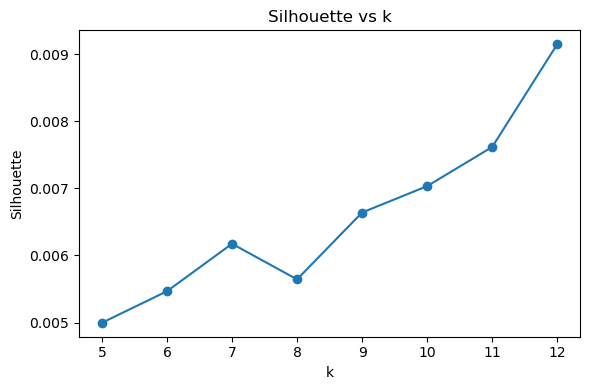

In [86]:
# 3a) Silhouette pada sampel (patokan utama)
sil_scores_euc = []
for k in K_VALUES:
    km = KMeans(n_clusters=k, random_state=RAND, n_init="auto")
    labels_k = km.fit_predict(X_sample_dense)
    s = silhouette_score(X_sample_dense, labels_k)  # euclidean
    sil_scores_euc.append(s)
    print(f"k={k}  silhouette={s:.4f}")

best_k_sil = K_VALUES[int(np.argmax(sil_scores_euc))]
print("Best k (silhouette):", best_k_sil)

plt.figure(figsize=(6,4))
plt.plot(K_VALUES, sil_scores_euc, "o-")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.title("Silhouette vs k")
plt.tight_layout(); plt.show()


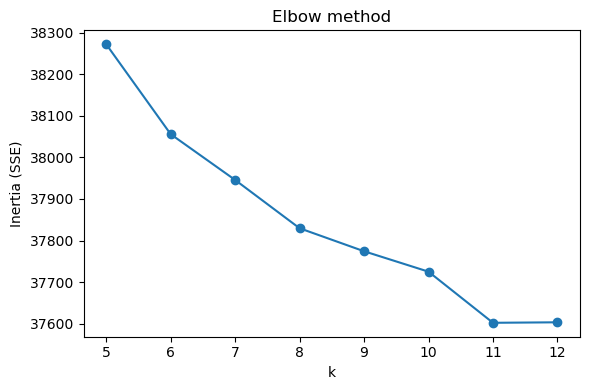

Elbow k (rel. drop max): 6


In [87]:
# 3b) Elbow (inertia/SSE) pada seluruh data
inertias = []
for k in K_VALUES:
    km = KMeans(n_clusters=k, random_state=RAND, n_init="auto").fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_VALUES, inertias, "o-")
plt.xlabel("k"); plt.ylabel("Inertia (SSE)")
plt.title("Elbow method")
plt.tight_layout(); plt.show()

# deteksi siku sederhana: pilih rasio penurunan terbesar
rel_drops = -np.diff(inertias) / np.array(inertias[:-1])
elbow_idx = int(np.argmax(rel_drops)) + 1
elbow_k = K_VALUES[elbow_idx]
print("Elbow k (rel. drop max):", elbow_k)


In [88]:
# 3c) metrik pendukung pada sampel 
ch_scores, db_scores = [], []
for k in K_VALUES:
    km = KMeans(n_clusters=k, random_state=RAND, n_init="auto")
    lbl = km.fit_predict(X_sample_dense)
    ch_scores.append(calinski_harabasz_score(X_sample_dense, lbl))  # lebih besar lebih baik
    db_scores.append(davies_bouldin_score(X_sample_dense, lbl))     # lebih kecil lebih baik

print("Best k (CH):", K_VALUES[int(np.argmax(ch_scores))])
print("Best k (DB):", K_VALUES[int(np.argmin(db_scores))])


Best k (CH): 5
Best k (DB): 11


# K-Final

In [89]:
def pick_final_k(K_VALUES, sil_scores, elbow_k, margin=0.003):
    # margin = seberapa besar peningkatan silhouette yang dianggap "layak"
    sil_map = {k: s for k, s in zip(K_VALUES, sil_scores)}
    s_elbow = sil_map.get(elbow_k, None)
    s_best  = max(sil_scores)
    k_best  = K_VALUES[int(np.argmax(sil_scores))]
    if s_elbow is not None and (s_best - s_elbow) <= margin:
        return elbow_k, {"reason": f"elbow {elbow_k} dipilih karena gain silhouette {s_best - s_elbow:.4f} kecil (<= {margin})"}
    return k_best, {"reason": f"silhouette maksimum di k={k_best} dengan gain signifikan atas elbow"}

final_k, why = pick_final_k(K_VALUES, sil_scores_euc, elbow_k, margin=0.003)
print("Final k:", final_k, "|", why["reason"])


Final k: 12 | silhouette maksimum di k=12 dengan gain signifikan atas elbow


# Fit K-Means

In [90]:
kmeans = KMeans(n_clusters=final_k, random_state=RAND, n_init="auto")
df["cluster"] = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_
df["cluster"].value_counts().sort_index()


cluster
0       723
1      1229
2     18185
3       225
4       915
5       855
6      2880
7      2152
8       315
9      5063
10     1074
11     6204
Name: count, dtype: int64

# Top Terms Every Cluster

In [91]:
def top_terms(centers, terms, topn=18):
    out = []
    for i in range(centers.shape[0]):
        idx = np.argsort(centers[i])[::-1][:topn]
        out.append((i, [terms[j] for j in idx]))
    return out

tops = top_terms(centers, terms, topn=18)
for c, words in tops:
    print(f"Cluster {c}: {', '.join(words)}")

cluster_name = {c: ", ".join(words[:3]) for c, words in tops}
df["cluster_name"] = df["cluster"].map(cluster_name)

Cluster 0: moba, game moba, game, moba baik, baik, moba belah, belah, best, best moba, bagus, moba bagus, mobile, moba mobile, main, keren, tidak, seru, nya
Cluster 1: ml, bagus ml, game, bagus, tidak, main ml, player ml, main, nya, mending, plagiat, kaya ml, game ml, kaya, player, seru, kayak ml, mending ml
Cluster 2: game, bagus, nya, main, suka, mantap, seru, banget, keren, hero, skin, bintang, download, update, ya, kasih, grafik, udah
Cluster 3: mainin, game, mainin game, tidak mainin, nya, tidak, banget, enak mainin, bagus, seru, enak, main, udah, game nya, moba, gua, pas, jelek
Cluster 4: bagus, game bagus, game, bagus banget, bagus game, banget, belah, bagus bagus, game belah, bagus main, main, suka, bagus suka, bagus grafik, grafik, bagus tidak, hero, nya
Cluster 5: gamenya, gamenya bagus, bagus, bagus gamenya, gamenya seru, seru, banget, keren, bagus banget, gamenya keren, mantap, mantap gamenya, suka, banget gamenya, suka gamenya, tidak, keren gamenya, seru banget
Cluster 6: 

# Issue Comparation of Games

In [92]:
dist = pd.crosstab(df["game"], df["cluster"], normalize="index") * 100
dist_named = pd.crosstab(df["game"], df["cluster_name"], normalize="index") * 100

print("Distribusi per cluster id (%):")
display(dist.round(2))
print("\nDistribusi per nama isu (%):")
display(dist_named.round(2))


Distribusi per cluster id (%):


cluster,0,1,2,3,4,5,6,7,8,9,10,11
game,,,,,,,,,,,,
AOV,2.17,2.20,46.71,0.60,2.34,2.23,2.32,4.30,1.00,9.95,10.19,15.99
HOK,2.10,5.49,49.27,0.64,3.12,3.23,7.17,8.22,1.20,5.47,0.38,13.71
LoL,2.61,3.75,61.17,0.41,2.54,2.06,1.61,3.85,0.47,8.13,0.13,13.29
MLBB,0.40,0.92,25.80,0.61,1.20,1.07,17.73,5.22,0.49,27.23,0.04,19.29



Distribusi per nama isu (%):


cluster_name,"aov, main aov, main","bagus, game bagus, game","baik, jaring, tolong","game nya, nya, nya bagus","game, bagus, nya","gamenya, gamenya bagus, bagus","lumayan, lumayan bagus, bagus","mainin, game, mainin game","ml, bagus ml, game","moba, game moba, game","tidak, game, main","tim, main, tidak"
game,,,,,,,,,,,,
AOV,10.19,2.34,9.95,4.30,46.71,2.23,1.00,0.60,2.20,2.17,15.99,2.32
HOK,0.38,3.12,5.47,8.22,49.27,3.23,1.20,0.64,5.49,2.10,13.71,7.17
LoL,0.13,2.54,8.13,3.85,61.17,2.06,0.47,0.41,3.75,2.61,13.29,1.61
MLBB,0.04,1.20,27.23,5.22,25.80,1.07,0.49,0.61,0.92,0.40,19.29,17.73


# Visualisation

## PCA 2D 

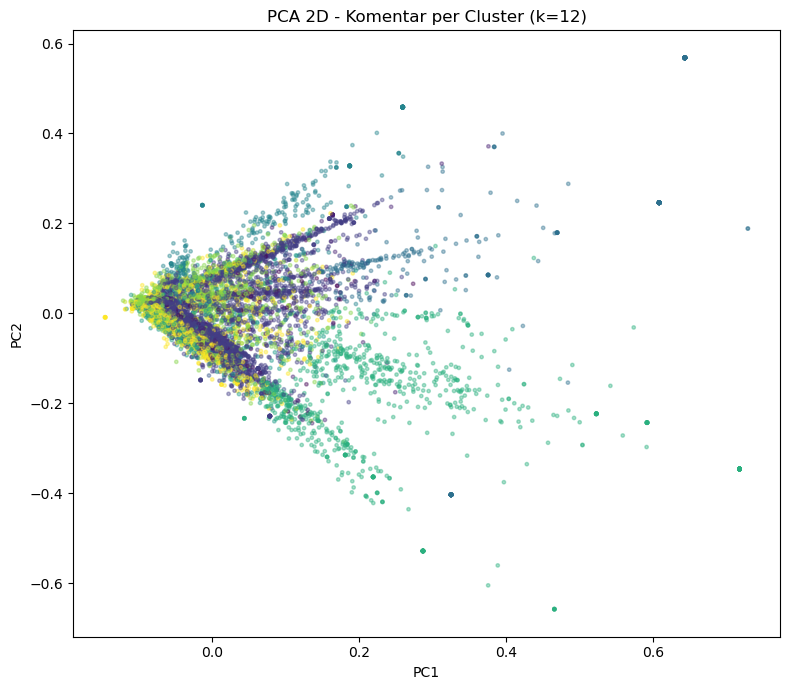

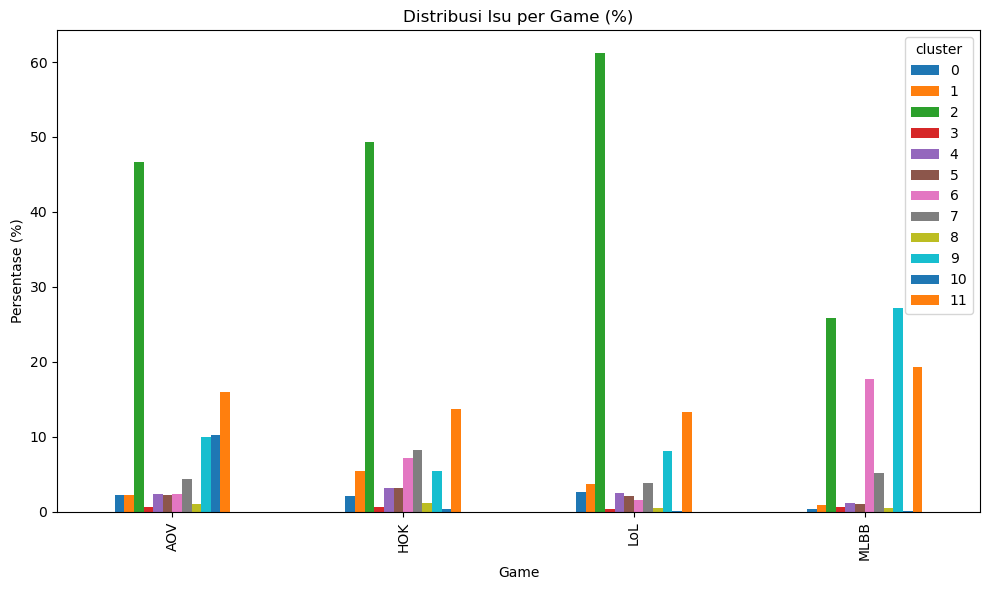

In [93]:
# PCA 2D pakai sampling agar ringan
sub_n = min(15000, X.shape[0])
sub_idx = rng.choice(X.shape[0], size=sub_n, replace=False)
X_dense = X[sub_idx].toarray()
y_sub = df["cluster"].iloc[sub_idx].to_numpy()

X2 = PCA(n_components=2, random_state=RAND).fit_transform(X_dense)
plt.figure(figsize=(8,7))
plt.scatter(X2[:,0], X2[:,1], c=y_sub, s=6, alpha=0.4)
plt.title(f"PCA 2D - Komentar per Cluster (k={final_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

ax = dist.plot(kind="bar", figsize=(10,6))
ax.set_title("Distribusi Isu per Game (%)")
ax.set_xlabel("Game"); ax.set_ylabel("Persentase (%)")
plt.tight_layout(); plt.show()


# Save Result

In [94]:
cols = ["reviewId","game","cluster","cluster_name",TEXT_COL]
for c in ["score","thumbsUpCount","at","appVersion","content"]:
    if c in df.columns: cols.append(c)

df[cols].to_csv("assignments_with_topics.csv", index=False)
dist.round(2).to_csv("per_game_distribution.csv")
pd.DataFrame([{"cluster": c, "top_terms": ", ".join(ws)} for c, ws in tops]) \
  .to_csv("cluster_top_terms.csv", index=False)
